In [26]:
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
import scipy.spatial as scspatial
from desmin_reconstruction.plotting.plot_2d import plot_line_and_band
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


pv.set_jupyter_backend("static")

df = pl.read_csv("./data/STORM/desmin_alphaactinin_600nm.csv")
df.head()

shape: (5, 32)
┌──────────┬───────┬────────┬───────┬───┬───────┬────────┬────────┬────────┐
│ image-ID ┆ cycle ┆ z-step ┆ frame ┆ … ┆ valid ┆ driftx ┆ drifty ┆ driftz │
│ ---      ┆ ---   ┆ ---    ┆ ---   ┆   ┆ ---   ┆ ---    ┆ ---    ┆ ---    │
│ i64      ┆ i64   ┆ i64    ┆ i64   ┆   ┆ i64   ┆ i64    ┆ i64    ┆ i64    │
╞══════════╪═══════╪════════╪═══════╪═══╪═══════╪════════╪════════╪════════╡
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
│ 0        ┆ 0     ┆ 0      ┆ 0     ┆ … ┆ 1     ┆ 0      ┆ 0      ┆ 0      │
└──────────┴───────┴────────┴───────┴───┴───────┴────────┴────────┴────────┘

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        8.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 7.000e+00,
        8.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 4.000e+00, 5.000e+00, 2.000e+00, 8.000e+00,
        2.000e+00, 8.000e+00, 0.000e+00, 6.000e+00, 4.000e+00, 1.200e+01,
        5.000e+00, 3.000e+00, 7.000e+00, 1.000e+00, 6.000e+00, 6.000e+00,
        3.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 8.000e+00, 5.000e+00,
        3.000e+00, 7.000e+00, 5.000e+00, 5.000e+00, 1.000e+01, 7.000e+00,
        5.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 1.000e+01, 2.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 1.100e+01, 4.000e+00,
        6.000e+00, 1.000e+01, 3.000e+00, 1.300e+01, 8.000e+00, 8.000e+00,
        2.000e+00, 4.000e+00, 5.000e+00, 1.000e+01, 7.000e+00, 6.000e+00,
        6.000e+00, 5.000e+00, 2.000e+0

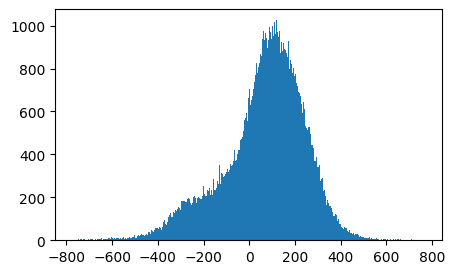

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(df["z"], bins=1000)


# ax.set_xscale("log", base = 10)

In [28]:
# df = df.filter((pl.col("z") >= -300) & (pl.col("z") <= 300))

In [29]:
out = df.partition_by("probe")
out[1].head()

shape: (5, 32)
┌──────────┬───────┬────────┬───────┬───┬───────┬────────┬────────┬────────┐
│ image-ID ┆ cycle ┆ z-step ┆ frame ┆ … ┆ valid ┆ driftx ┆ drifty ┆ driftz │
│ ---      ┆ ---   ┆ ---    ┆ ---   ┆   ┆ ---   ┆ ---    ┆ ---    ┆ ---    │
│ i64      ┆ i64   ┆ i64    ┆ i64   ┆   ┆ i64   ┆ i64    ┆ i64    ┆ i64    │
╞══════════╪═══════╪════════╪═══════╪═══╪═══════╪════════╪════════╪════════╡
│ 8399     ┆ 4     ┆ 0      ┆ 399   ┆ … ┆ 1     ┆ 23     ┆ 0      ┆ 0      │
│ 8399     ┆ 4     ┆ 0      ┆ 399   ┆ … ┆ 1     ┆ 23     ┆ 0      ┆ 0      │
│ 8399     ┆ 4     ┆ 0      ┆ 399   ┆ … ┆ 1     ┆ 23     ┆ 0      ┆ 0      │
│ 8399     ┆ 4     ┆ 0      ┆ 399   ┆ … ┆ 1     ┆ 23     ┆ 0      ┆ 0      │
│ 8399     ┆ 4     ┆ 0      ┆ 399   ┆ … ┆ 1     ┆ 23     ┆ 0      ┆ 0      │
└──────────┴───────┴────────┴───────┴───┴───────┴────────┴────────┴────────┘

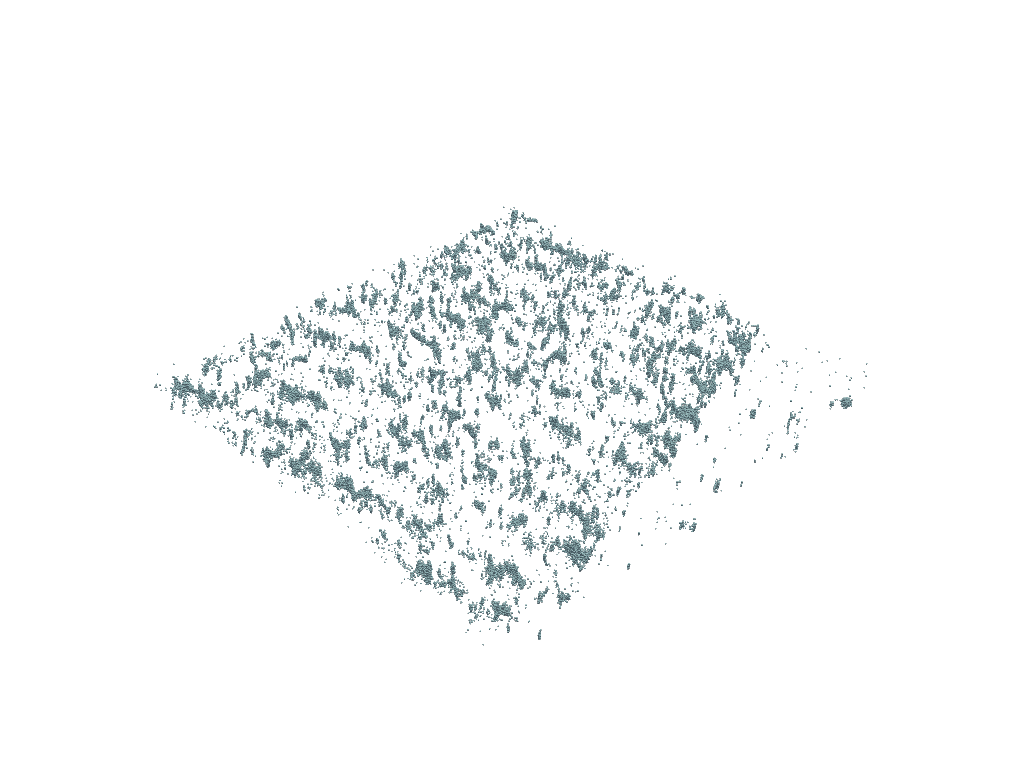

In [30]:
p = pv.Plotter()
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
p.add_mesh(point_cloud, render_points_as_spheres=True, point_size=2)
p.show()

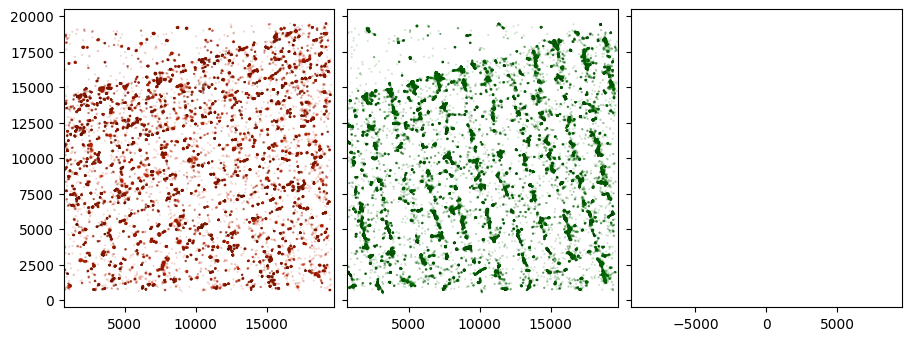

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.3), sharey=True, constrained_layout=True)
axes[0].scatter(
    out[0]["x"],
    out[0]["y"],
    s=0.2,
    c=np.log10(out[0]["amp"]),
    cmap=cc.cm.kr_r,
    alpha=0.2,
)
axes[1].scatter(
    out[1]["x"],
    out[1]["y"],
    s=0.2,
    c=np.log10(out[1]["amp"]),
    cmap=cc.cm.kg_r,
    alpha=0.2,
)
for ax in axes:
    ax.axis("equal")

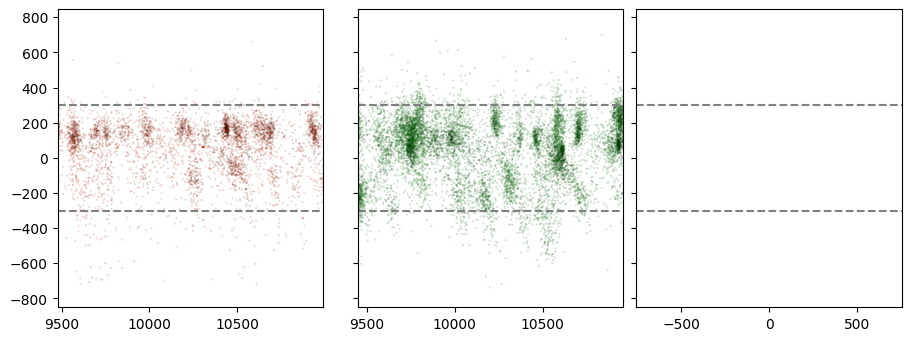

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.3), sharey=True, constrained_layout=True)
axes[0].scatter(
    out[0]["x"],
    out[0]["z"],
    s=0.2,
    c=np.log10(out[0]["amp"]),
    cmap=cc.cm.kr_r,
    alpha=0.2,
)
axes[1].scatter(
    out[1]["x"],
    out[1]["z"],
    s=0.2,
    c=np.log10(out[1]["amp"]),
    cmap=cc.cm.kg_r,
    alpha=0.2,
)
for ax in axes:
    ax.axis("equal")
    ax.axhline(y=300, linestyle="--", color="gray")
    ax.axhline(y=-300, linestyle="--", color="gray")

In [33]:
points = out[1].select(["x", "y", "z"]).to_numpy()
points.shape

(154160, 3)

In [34]:
voro = VoronoiAnalysis(points)
voro_rand = VoronoiAnalysis(random_uniform_like(points))

In [35]:
vol = voro.region_volumes
vol_rand = voro_rand.region_volumes

100%|██████████| 154160/154160 [00:37<00:00, 4109.23it/s]


In [12]:
voro.histogram_volume(bin_size=2e5, max_volume=2e7)

(array([116775,   6717,   3422,   2308,   1679,   1353,   1129,    975,
           755,    726,    669,    589,    485,    508,    464,    422,
           370,    389,    350,    319,    324,    305,    261,    231,
           227,    204,    207,    191,    195,    194,    175,    172,
           169,    163,    159,    160,    114,    126,    141,    123,
           127,    127,    121,    106,    119,     95,    100,    102,
           123,     87,     78,     72,     94,     70,     73,     79,
            89,     71,     71,     69,     74,     78,     63,     78,
            82,     53,     54,     45,     64,     61,     54,     48,
            50,     39,     63,     52,     57,     58,     44,     59,
            55,     44,     51,     38,     48,     48,     47,     54,
            34,     48,     59,     28,     33,     41,     41,     33,
            33,     34,     38]),
 array([       0.,   200000.,   400000.,   600000.,   800000.,  1000000.,
         1200000.,  1400000.

In [13]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


vols = determine_threshold(voro.points)

100%|██████████| 10/10 [08:02<00:00, 48.29s/it]


In [36]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins)

In [16]:
counts = [histogram_fixed_binsize(v, bin_size=2e5, max_value=4e7)[0] for v in vols]

In [27]:
counts_mean = np.mean(np.stack(counts, 0), axis=0)
counts_std = np.std(np.stack(counts, 0), axis=0)

In [23]:
counts_data, bins = voro.histogram_volume(bin_size=2e5, max_volume=4e7)

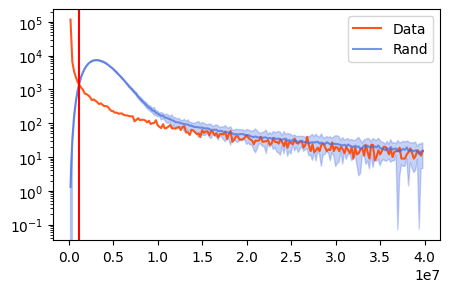

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(bins[1:], counts_data, alpha=0.9, color="orangered", label="Data")
ax = plot_line_and_band(
    ax, bins[1:], counts_mean, 3 * counts_std, alpha=0.7, label="Rand"
)
ax.set_yscale("log")
ax.axvline(
    x=1.1e6,
    color="red",
)
ax.legend()

In [ ]:
# points_filtered = points[vol <= 1100]
points_filtered = points[vol <= 0.6e6]
points_filtered.shape

(110880, 3)

TypeError: Axes.scatter() got multiple values for argument 's'

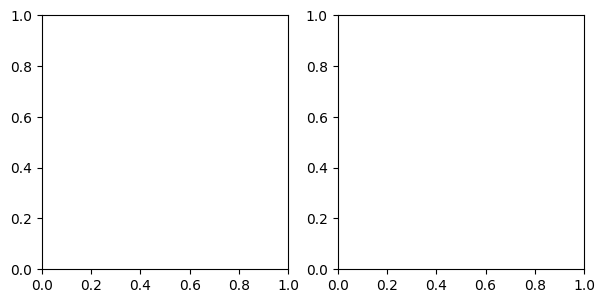

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.3))
axes[0].scatter(*points.T, s=0.1)
axes[1].scatter(*points_filtered.T, s=0.1)

In [37]:
def filter_by_voronoi_volume(points, vol_thres: float):
    voro = VoronoiAnalysis(points)
    vols = voro.region_volumes
    selection = vols <= vol_thres
    return voro.points[selection], vols[selection]

In [38]:
points_desmin = out[0].select(["x", "y", "z"]).to_numpy()
points_actinin = out[1].select(["x", "y", "z"]).to_numpy()
points_desmin_filtered, vols_desmin = filter_by_voronoi_volume(points_desmin, 1.1e6)
points_actinin_filtered, vols_actinin = filter_by_voronoi_volume(points_actinin, 0.6e6)

100%|██████████| 154160/154160 [00:36<00:00, 4191.09it/s]


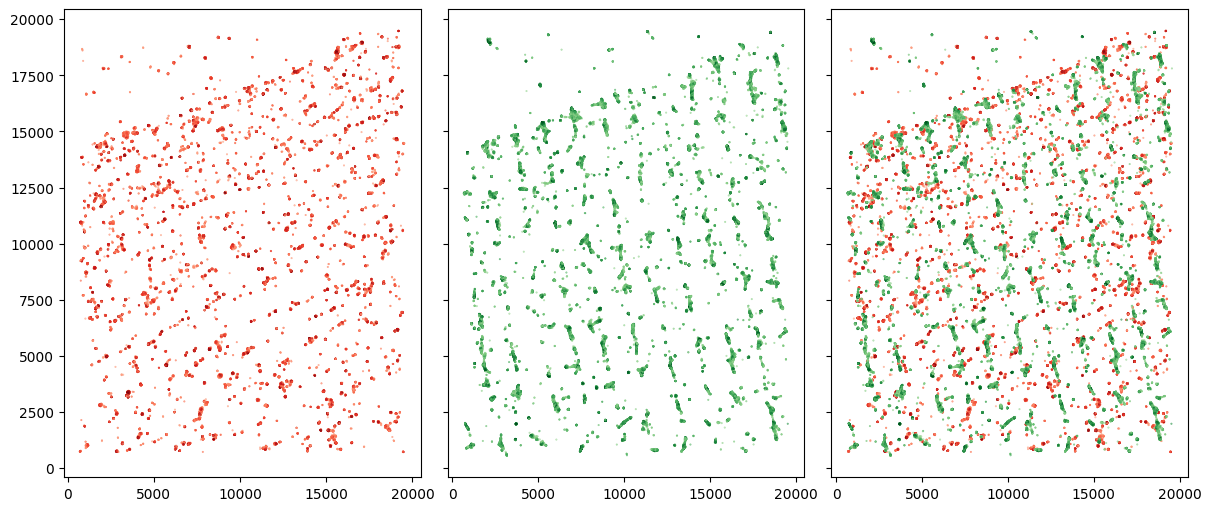

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, constrained_layout=True)
scatter_kwargs = {"alpha": 0.8, "s": 0.2, "edgecolor": None, "vmax": -3, "vmin": -7.5}
axes[0].scatter(
    *(points_desmin_filtered.T[:2]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)
axes[1].scatter(
    *(points_actinin_filtered.T[:2]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)
axes[2].scatter(
    *(points_desmin_filtered.T[:2]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)
axes[2].scatter(
    *(points_actinin_filtered.T[:2]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)

(array([6510., 6995., 7980., 9070., 9511., 7594., 4919., 2099.,  523.,
          46.]),
 array([-6.04133578, -5.6056092 , -5.16988262, -4.73415603, -4.29842945,
        -3.86270287, -3.42697629, -2.9912497 , -2.55552312, -2.11979654,
        -1.68406996]),
 <BarContainer object of 10 artists>)

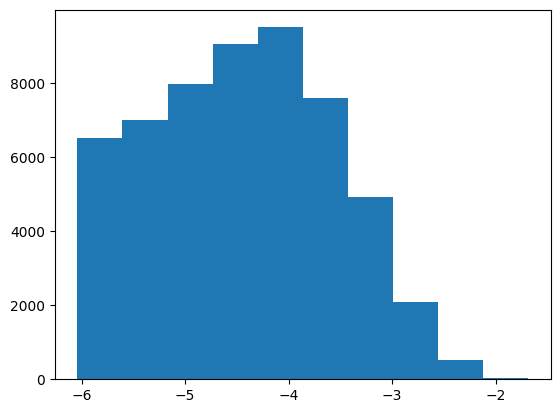

In [17]:
plt.hist(np.log10(1 / vols_desmin))

In [ ]:
from hdbscan import HDBSCAN


clusterer = HDBSCAN(min_cluster_size=500, min_samples=25, cluster_selection_epsilon=30)
clusterer.fit(points_actinin_filtered[:, np.array([0, 2])])


In [106]:
set(clusterer.labels_)

{np.int64(-1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44)}

In [107]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    cmap = plt.get_cmap("cet_glasbey_light")
    colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        ax.scatter(
            *X[labels == k].T,
            s=1 if k == -1 else 2,
            marker=".",
            facecolor=tuple(col),
            edgecolor=None,
            alpha=0.7,
        )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    title = f"Estimated number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

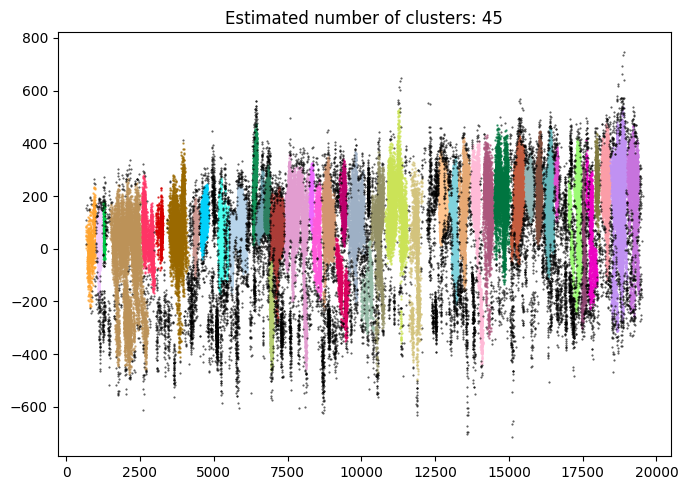

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_actinin_filtered[:, np.array([0, 2])], clusterer.labels_, ax=ax)

In [110]:
import sklearn

sklearn.metrics.calinski_harabasz_score(
    points_actinin_filtered[:, np.array([0, 2])], clusterer.labels_
)

26144.67735405349

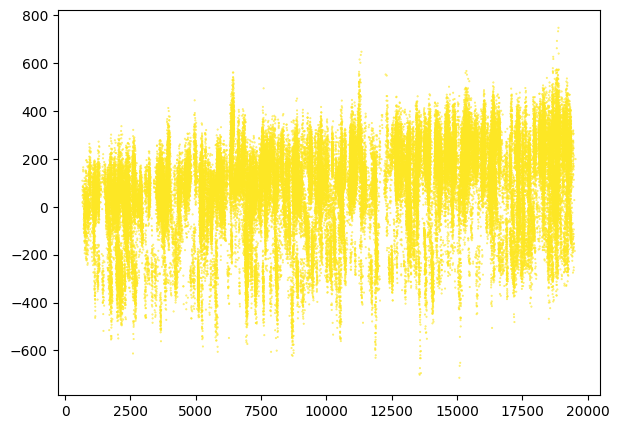

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(
    *(points_actinin_filtered.T[np.array([0, 2])]),
    c=clusterer.labels_,
    **scatter_kwargs,
)

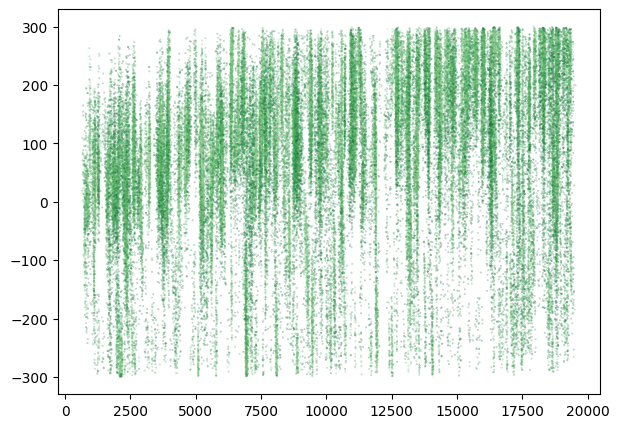

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(
    *(points_actinin_filtered.T[np.array([0, 2])]),
    c=np.log10(vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)

In [183]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=50)
metrics = []

angles = np.linspace(0, 15, 50)
for theta in tqdm(angles):
    r = scspatial.transform.Rotation.from_rotvec(
        theta * np.array([0, 0, -1]), degrees=True
    )
    points_rotated = r.apply(points_actinin_filtered)
    clusterer.fit(points_rotated[:, np.array([0, 2])])

    metrics.append(
        sklearn.metrics.calinski_harabasz_score(
            points_rotated[:, np.array([0, 2])], clusterer.labels_
        )
    )

100%|██████████| 50/50 [02:05<00:00,  2.50s/it]


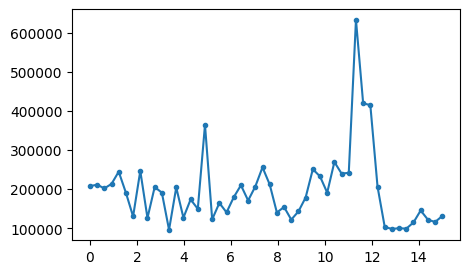

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(angles, np.array(metrics), ".-")

np.float64(10.90909090909091)

In [212]:
r = scspatial.transform.Rotation.from_rotvec(
    angles[np.argmax(np.array(metrics))] * np.array([0, 0, -1]), degrees=True
)
points_rotated = r.apply(points_actinin_filtered)

points_rotated_desmin = r.apply(points_desmin_filtered)

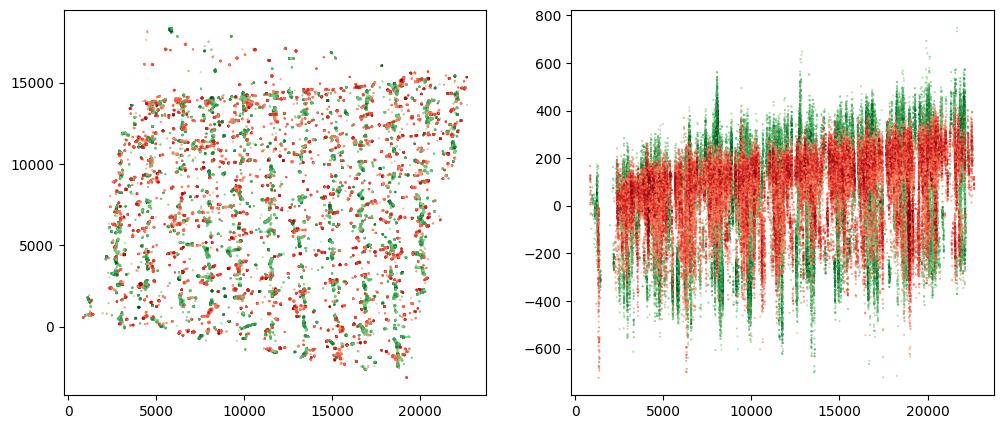

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(
    *(points_rotated.T[:2]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)
axes[1].scatter(
    *(points_rotated.T[np.array([0, 2])]),
    c=np.log10(1 / vols_actinin),
    cmap="Greens",
    **scatter_kwargs,
)

axes[0].scatter(
    *(points_rotated_desmin.T[:2]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)
axes[1].scatter(
    *(points_rotated_desmin.T[np.array([0, 2])]),
    c=np.log10(1 / vols_desmin),
    cmap="Reds",
    **scatter_kwargs,
)

In [191]:
clusterer = HDBSCAN(min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=50)
clusterer.fit(points_rotated[:, np.array([0, 2])])


HDBSCAN(cluster_selection_epsilon=50, min_cluster_size=1000, min_samples=20)

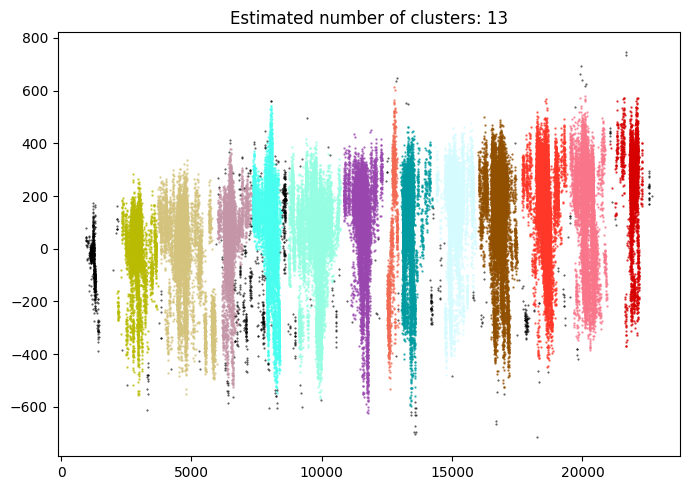

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[:, np.array([0, 2])], clusterer.labels_, ax=ax)

In [160]:
sklearn.metrics.calinski_harabasz_score(
    points_rotated[:, np.array([0, 2])], clusterer.labels_
)

269881.14093978785

(array([1.450e+02, 4.350e+02, 2.900e+01, 0.000e+00, 1.000e+00, 4.400e+01,
        9.700e+01, 7.160e+02, 3.424e+03, 2.398e+03, 2.740e+02, 1.810e+02,
        2.610e+02, 3.340e+02, 5.300e+02, 5.850e+02, 4.926e+03, 4.689e+03,
        2.270e+02, 3.490e+02, 3.750e+02, 2.700e+02, 1.005e+03, 1.450e+02,
        1.852e+03, 5.115e+03, 8.480e+02, 2.850e+02, 2.660e+02, 7.020e+02,
        9.010e+02, 1.175e+03, 5.272e+03, 4.154e+03, 5.620e+02, 2.400e+02,
        9.350e+02, 6.970e+02, 7.580e+02, 1.157e+03, 5.243e+03, 3.598e+03,
        8.490e+02, 4.710e+02, 2.150e+02, 1.720e+02, 1.530e+02, 9.120e+02,
        5.076e+03, 3.645e+03, 4.150e+02, 1.700e+02, 9.500e+01, 6.480e+02,
        7.780e+02, 2.100e+02, 4.106e+03, 5.687e+03, 2.620e+02, 9.600e+01,
        1.310e+02, 6.400e+01, 6.900e+01, 4.420e+02, 4.096e+03, 2.930e+03,
        8.920e+02, 2.410e+02, 5.110e+02, 2.160e+02, 7.140e+02, 1.145e+03,
        3.329e+03, 4.955e+03, 1.118e+03, 1.990e+02, 3.700e+01, 2.780e+02,
        1.600e+02, 1.472e+03, 4.448e+0

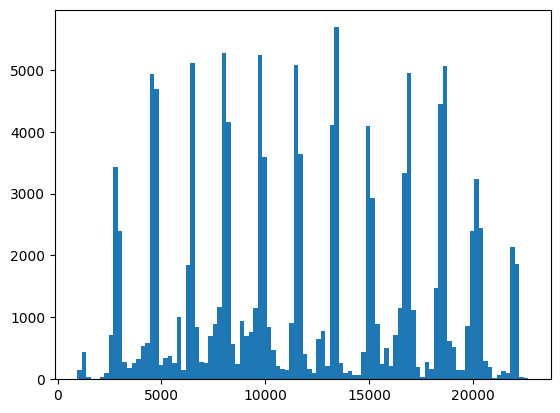

In [210]:
plt.hist(points_rotated[:, 0], bins=100)

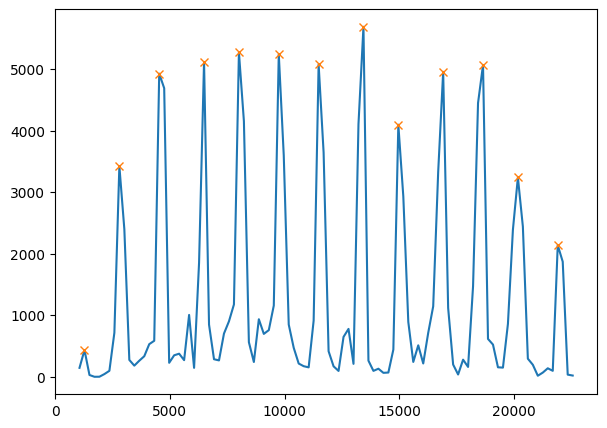

In [209]:
import scipy

counts, bin_edges = np.histogram(points_rotated[:, 0], bins=100)
bin_pos = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Find peaks with separation more than the known sarcomere length (~1.6um)
peaks, _ = scipy.signal.find_peaks(counts, distance=1500 / (bin_pos[1] - bin_pos[0]))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(bin_pos, counts)
ax.plot(bin_pos[peaks], counts[peaks], "x")

(126914,)

In [218]:
actinin_distances = np.min(
    np.abs(points_rotated[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)
desmin_distances = np.min(
    np.abs(points_rotated_desmin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

Text(0, 0.5, 'Probability')

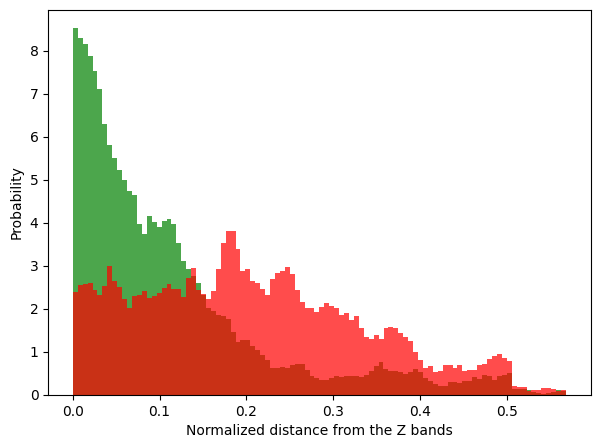

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.hist(
    actinin_distances / mean_sarcomere_length,
    bins=100,
    density=True,
    alpha=0.7,
    color="green",
)
ax.hist(
    desmin_distances / mean_sarcomere_length,
    bins=100,
    density=True,
    alpha=0.7,
    color="red",
)
ax.set_xlabel("Normalized distance from the Z bands")
ax.set_ylabel("Probability")

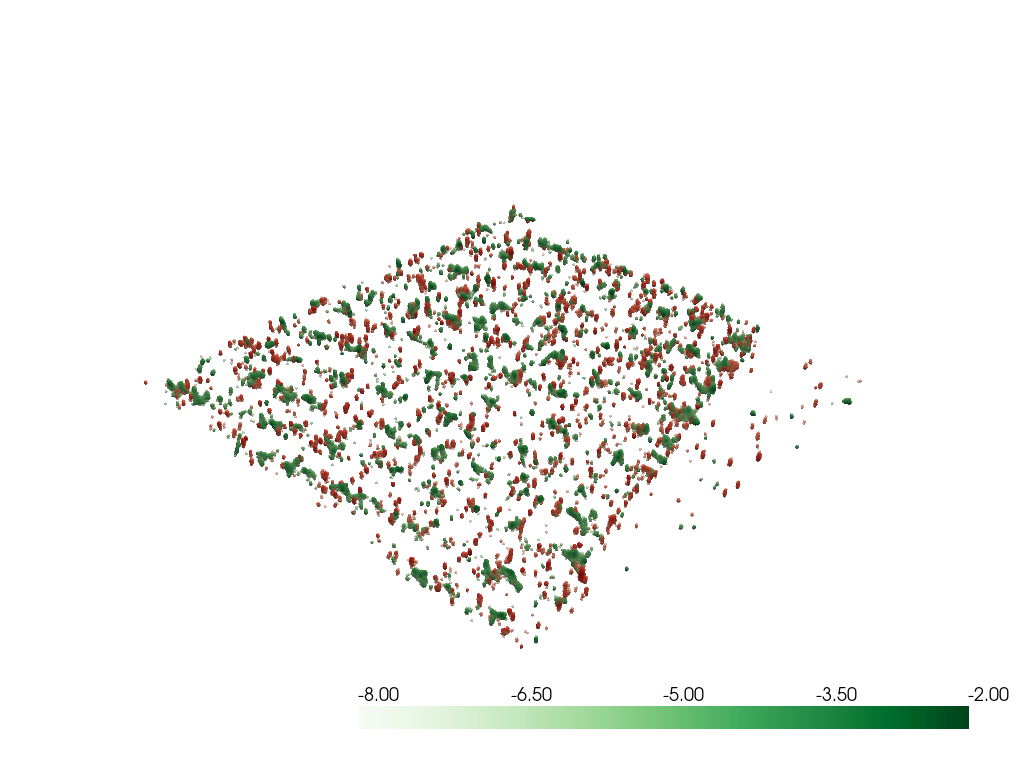

In [83]:
p = pv.Plotter()
point_cloud_desmin = pv.PolyData(points_desmin_filtered)
point_cloud_actinin = pv.PolyData(points_actinin_filtered)
p.add_mesh(
    point_cloud_desmin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_desmin),
    cmap="Reds",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
p.add_mesh(
    point_cloud_actinin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_actinin),
    cmap="Greens",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
# p.camera_position = "xy"
p.show()

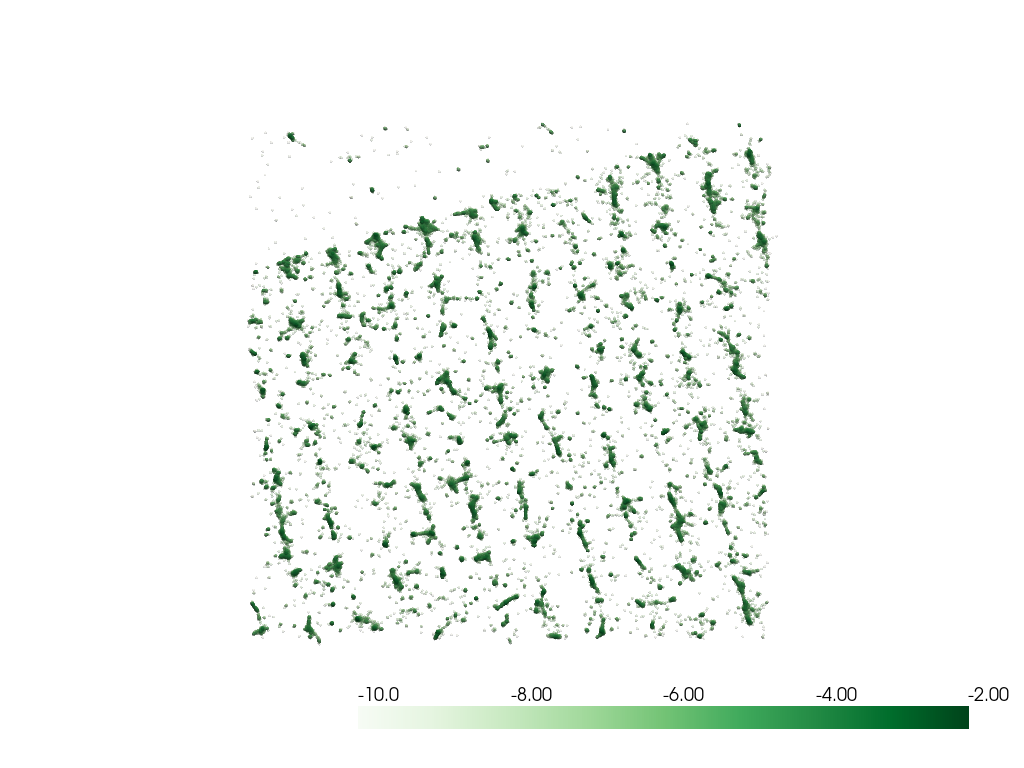

In [55]:
p = pv.Plotter()
point_cloud = pv.PolyData(points)
p.add_mesh(
    point_cloud,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vol + 1e-18),
    cmap="Greens",
    clim=(-10, -2),
    show_edges=False,
    opacity=0.3,
)
p.camera_position = "xy"
p.show()

In [84]:
points.shape

(134279, 3)

In [85]:
vol.shape

(134279,)

In [86]:
grids = np.meshgrid(*[np.arange(b_min[i], b_max[i], 20) for i in range(len(b_min))])
grids[0].shape

(952, 959, 30)

In [87]:
grids = np.stack(grids, axis=-1)

In [88]:
grids.shape

(952, 959, 30, 3)

In [ ]:
import scipy.interpolate as scinterpolate


interpolator = scinterpolate.RBFInterpolator(points, 1 / vol + 1e-18, neighbors=500)
interp_results = scinterpolate.griddata(points, 1 / vol + 1e-18, grids.reshape(-1, 3))

In [90]:
out = interp_results.reshape(*grids.shape[:-1])

In [91]:
density = 1 / vol
np.min(density[density > 0])

np.float64(2.129564936558756e-18)

(array([3.041800e+04, 8.200000e+01, 1.140000e+02, 1.520000e+02,
        2.060000e+02, 2.960000e+02, 4.300000e+02, 6.410000e+02,
        8.840000e+02, 1.213000e+03, 1.686000e+03, 2.197000e+03,
        2.750000e+03, 3.145000e+03, 3.129000e+03, 2.468000e+03,
        1.807000e+03, 2.395000e+03, 3.382000e+03, 4.567000e+03,
        5.945000e+03, 8.131000e+03, 1.086600e+04, 1.252100e+04,
        1.437100e+04, 1.506100e+04, 1.777500e+04, 2.446100e+04,
        3.006100e+04, 3.458600e+04, 4.029300e+04, 4.442000e+04,
        4.963100e+04, 4.889600e+04, 4.646800e+04, 5.107800e+04,
        6.487800e+04, 7.281300e+04, 7.079000e+04, 6.911000e+04,
        9.101900e+04, 1.141700e+05, 1.299290e+05, 1.273580e+05,
        1.208600e+05, 1.127110e+05, 1.245160e+05, 1.574150e+05,
        1.775980e+05, 2.311830e+05, 2.651020e+05, 3.272720e+05,
        3.980720e+05, 4.649030e+05, 5.061350e+05, 5.567360e+05,
        6.299040e+05, 7.890790e+05, 9.457690e+05, 1.129197e+06,
        1.362705e+06, 1.599159e+06, 1.78

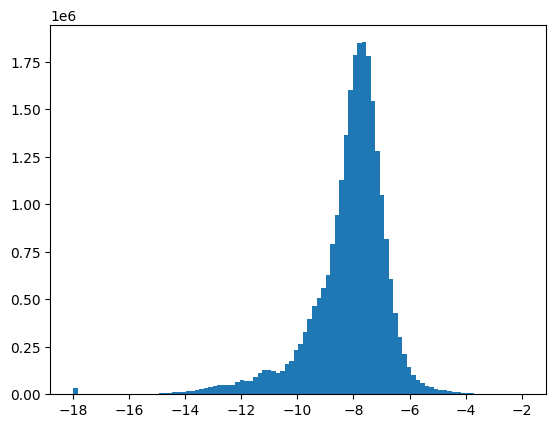

In [92]:
plt.hist(np.log10(interp_results), bins=100)

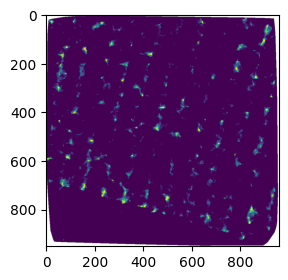

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.imshow(
    np.log10(out[:, :, 10]),
    vmin=np.log10(1 / 0.6e6) - 1,
    vmax=np.log10(1 / 0.6e6) + 1,
)

In [89]:
np.log10(1 / 0.6e6)

np.float64(-5.778151250383644)

/tmp/ipykernel_850234/1718147273.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(interp_results).flatten(), bins=100)


ValueError: supplied range of [-inf, -2.31724829161289] is not finite

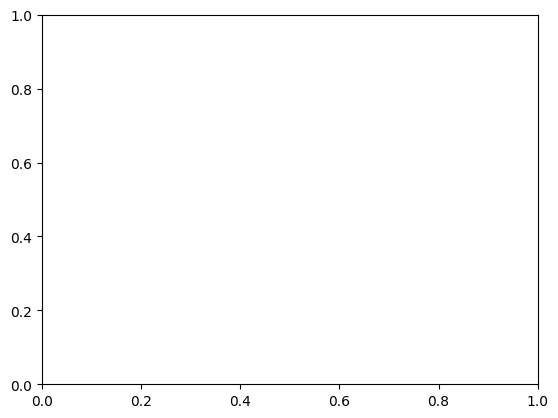

In [34]:
plt.hist(np.log10(interp_results).flatten(), bins=100)